In [23]:
# Imports
import numpy as np
import zarr

In [24]:
# Create data to store in the Zarr store
ZARRVERSION = 3  # Specify Zarr version

data = np.random.rand(100, 100).astype('float32')

sparse_data = np.random.rand(1000, 1000).astype('float32')
sparse_data[sparse_data < 0.8] = 0  # Make it sparse

# For Zarr v3, use codecs instead of compressor
if ZARRVERSION == 2:
    """ 
    Customise compressor OPTIONAL it might improve compression rate
    """
    compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
    zarr_store = zarr.open('random_example.zarr', mode='w', shape=data.shape, dtype=data.dtype, compressor=compressor, chunks=(50, 50))
    sparse_zarr_store = zarr.open('sparse_example.zarr', mode='w', shape=sparse_data.shape, dtype=sparse_data.dtype, compressor=compressor, chunks=(100, 100))

else:
    """
    # Optional codecs configuration for Zarr v3
    from zarr.codecs import BytesCodec, BloscCodec, BloscCname, BloscShuffle
    codecs = [BytesCodec(endian='little'),
              BloscCodec(cname=BloscCname.zstd,
                         clevel=3,
                         shuffle=BloscShuffle.bitshuffle,
                         typesize=4)
              ]
    zarr_store = zarr.open('example.zarr', mode='w', shape=data.shape, dtype=data.dtype, codecs=codecs)
    """
    zarr_store = zarr.open('random_example.zarr', mode='w', shape=data.shape, dtype=data.dtype)
    sparse_zarr_store = zarr.open('sparse_example.zarr', mode='w', shape=sparse_data.shape, dtype=sparse_data.dtype)

zarr_store[:] = data
sparse_zarr_store[:] = sparse_data

print("Data written to Zarr store 'random_example.zarr'.")
print("Data written to Zarr store 'sparse_example.zarr'.")


Data written to Zarr store 'random_example.zarr'.
Data written to Zarr store 'sparse_example.zarr'.


### Explanation of Zarr Store Creation

```python
zarr.open(
    'example.zarr',
    mode='w',
    shape=data.shape,
    dtype=data.dtype,
    compressor=zarr.Blosc(cname='zstd', clevel=3, shuffle=2),
    chunks=(50, 50)  # Optional: specify chunk size
)
```

- **'example.zarr'**: Path to the Zarr store on disk.
- **mode='w'**: Write mode; creates a new store or overwrites an existing one.
- **shape=data.shape**: Shape of the array to store (e.g., (100, 100)).
- **dtype=data.dtype**: Data type of the array (e.g., float32).
- **compressor=zarr.Blosc(...)**: Use Blosc compressor with Zstandard codec, compression level 3, and byte shuffling.
- **chunks=(50, 50)**: (Optional) Store data in 50x50 blocks for efficient access and better compression.

**Codecs reference**: [Zarr Codecs Documentation](https://zarr-specs.readthedocs.io/en/latest/v3/codecs/index.html)

**Using chunks is recommended** for large arrays, as it improves read/write performance and compression.

In [17]:
# Load data from the Zarr store
loaded_data = zarr.open('sparse_example.zarr', mode='r')
print("Data loaded from Zarr store 'sparse_example.zarr':")
print(loaded_data[:])

Data loaded from Zarr store 'sparse_example.zarr':
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.91083264 0.        ]
 ...
 [0.82230574 0.         0.         ... 0.         0.         0.        ]
 [0.9879467  0.80044    0.         ... 0.         0.         0.89249533]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [27]:
# Compare size of compressed vs uncompressed data
original_size = data.nbytes
zarr_size = zarr_store.nbytes_stored() if ZARRVERSION == 3 else zarr_store.nbytes_stored
sparse_original_size = sparse_data.nbytes
sparse_zarr_size = sparse_zarr_store.nbytes_stored() if ZARRVERSION == 3 else sparse_zarr_store.nbytes_stored
print(f"Original data size: {original_size} bytes")
print(f"Zarr stored data size: {zarr_size} bytes")
print("Compression rate for dense data: {:.2f}%".format((1 - zarr_size / original_size) * 100))
print(f"Sparse original data size: {sparse_original_size} bytes")
print(f"Sparse Zarr stored data size: {sparse_zarr_size} bytes")
print("Compression rate for sparse data: {:.2f}%".format((1 - sparse_zarr_size / sparse_original_size) * 100))

Original data size: 40000 bytes
Zarr stored data size: 36476 bytes
Compression rate for dense data: 8.81%
Sparse original data size: 4000000 bytes
Sparse Zarr stored data size: 961559 bytes
Compression rate for sparse data: 75.96%


In [ ]:
# Create a group structure in Zarr V2 or V3
if ZARRVERSION == 2:
    root = zarr.open('grouped_example.zarr', mode='w')
    group1 = root.create_group('group1')

    group1.create_dataset('data1', data=np.random.rand(50, 50).astype('float32'))
    group1.create_dataset('data2', data=np.random.rand(30, 30).astype('float32'))
    group2 = root.create_group('group2')
    group2.create_dataset('data3', data=np.random.rand(20, 20).astype('float32'))

    print("Data written to Zarr store 'grouped_example.zarr' with groups and datasets.")
else:
    root = zarr.open('grouped_example.zarr', mode='w')
    group1 = root.create_group('group1')
    group2 = root.create_group('group2')

    # Always specify shape for v3, and use create_array (recommended)
    group1.create_array('data1', data=np.random.rand(50, 50).astype('float32'))
    group1.create_array('data2', data=np.random.rand(30, 30).astype('float32'))
    group2.create_array('data3', data=np.random.rand(20, 20).astype('float32'))

    print("Data written to Zarr store 'grouped_example.zarr' with groups and datasets.")

Data written to Zarr store 'second_grouped_example.zarr' with groups and datasets.


In [ ]:
# Add metadata to a grouped Zarr store zarr specifications v2 (...and v3?)
root.attrs['description'] = 'This is a grouped Zarr store example'
root.attrs['version'] = '1.0'
print("Metadata added to 'grouped_example.zarr':")
print(root.attrs.asdict())


Metadata added to 'second_grouped_example.zarr':


In [22]:
from time import time
from PIL import Image

# Create a random rgb image (int 8) 1024 x 1024 x 3
rgb_image = np.random.randint(0, 256, size=(1024, 1024, 3), dtype=np.uint8)

# Use pillow to save and load the image
img = Image.fromarray(rgb_image)
start_time = time()
img.save('random_image.png')
save_time = time() - start_time
loaded_img = Image.open('random_image.png')
loaded_rgb_image = np.array(loaded_img)
load_time = time() - (start_time + save_time)
print("Random RGB image saved and loaded using Pillow.")
print(f"Save time: {save_time:.4f} seconds")
print(f"Load time: {load_time:.4f} seconds")

# Codec
from zarr.codecs import BytesCodec, BloscCodec, BloscCname, BloscShuffle
codecs = [BytesCodec(endian='little'),
          BloscCodec(cname=BloscCname.lz4, clevel=1,
                     shuffle=BloscShuffle.noshuffle,  # uint8 images: usually no shuffle
                     typesize=1)]


# Save and load the same image using Zarr
zarr_image_store = zarr.open('random_image.zarr', 
                             mode='w', 
                             shape=rgb_image.shape, 
                             dtype=rgb_image.dtype, 
                             chunks=(512, 512, 3),
                             codecs=None)
start_time = time()
zarr_image_store[:] = rgb_image
zarr_save_time = time() - start_time
start_time = time()
loaded_zarr_image = zarr.open('random_image.zarr', mode='r')
loaded_rgb_image_zarr = loaded_zarr_image[:]
zarr_load_time = time() - start_time
print("Random RGB image saved and loaded using Zarr.")
print(f"Zarr save time: {zarr_save_time:.4f} seconds")
print(f"Zarr load time: {zarr_load_time:.4f} seconds")



# Print zarr gain in load time
load_time_gain = round(load_time / zarr_load_time, 2)
print(f"Zarr load time gain: {load_time_gain} X")


Random RGB image saved and loaded using Pillow.
Save time: 0.2575 seconds
Load time: 0.0419 seconds
Random RGB image saved and loaded using Zarr.
Zarr save time: 0.0146 seconds
Zarr load time: 0.0049 seconds
Zarr load time gain: 8.57 X


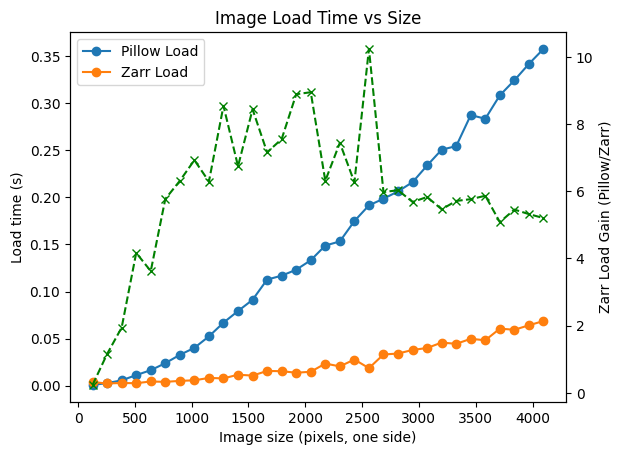

In [ ]:
import numpy as np
from PIL import Image
import zarr
from time import time
import matplotlib.pyplot as plt

def scan_image_io(sizes):
    pillow_load, zarr_load, zarr_gain = [], [], []
    for s in sizes:
        img = np.random.randint(0, 256, (s, s, 3), np.uint8)
        # Pillow
        Image.fromarray(img).save('tmp.png')
        t0 = time(); _ = np.array(Image.open('tmp.png')); pillow_load.append(time()-t0)
        # Zarr
        zarr.open('tmp.zarr', mode='w', shape=img.shape, dtype=img.dtype, chunks=(min(512,s),min(512,s),3))[:] = img
        t0 = time(); _ = zarr.open('tmp.zarr', mode='r')[:]; zarr_load.append(time()-t0)
        zarr_gain.append(pillow_load[-1]/zarr_load[-1] if zarr_load[-1]>0 else np.nan)
    return pillow_load, zarr_load, zarr_gain

sizes = range(128, 4097, 128)
pillow_load, zarr_load, zarr_gain = scan_image_io(sizes)

plt.plot(sizes, pillow_load, 'o-', label='Pillow Load')
plt.plot(sizes, zarr_load, 'o-', label='Zarr Load')
plt.xlabel('Image size (pixels, one side)')
plt.ylabel('Load time (s)')
plt.legend(loc='upper left')
plt.twinx().plot(sizes, zarr_gain, 'x--g', label='Zarr Load Gain')
plt.ylabel('Zarr Load Gain (Pillow/Zarr)')
plt.title('Image Load Time vs Size')
plt.show()

In [14]:
import numpy as np
import zarr
from concurrent.futures import ThreadPoolExecutor

def write_to_zarr(image_array, zarr_path):
    root = zarr.open(zarr_path, mode='a')
    for i in range(image_array.shape[0]):
        root.create_array(f'image_{i}', data=image_array[i], chunks=(512, 512, 3))

image_array = np.array([np.random.randint(0, 256, (512, 512, 3), np.uint8) for _ in range(50)])
print(image_array.shape)

zarr_path = 'random_images.zarr'

with ThreadPoolExecutor() as executor:
    executor.submit(write_to_zarr, image_array, zarr_path)


(50, 512, 512, 3)
